In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime

In [2]:
from research.strings import TARGET, PREDICTORS, INSPECTORS
from research.evaluation import evaluate_model

In [3]:
d_train = pd.read_csv("data/train_data.csv")
y_train = d_train[TARGET]
X_train = d_train[PREDICTORS]

In [4]:
d_test = pd.read_csv("data/test_data.csv")
y_test = d_test[TARGET]
X_test = d_test[PREDICTORS]
clf = pickle.load(open("models/sklearn-glm.pkl", "rb"))
evaluate_model(y_test, clf.predict(X_test))

F1 Score = 0.08664
Precision = 0.63158
Recall = 0.04651


,Predicted +,Predicted -
Actual +,12,246
Actual -,7,1372


In [6]:
d_train["inspector"] = d_train[INSPECTORS].idxmax(axis=1).apply(lambda x: str(x)[10:])
d_test["inspector"] = d_test[INSPECTORS].idxmax(axis=1).apply(lambda x: str(x)[10:])
d_test.head()

,criticalFound,Inspection_Date,License,Inspection_ID,Business_ID,Inspector_blue,Inspector_brown,Inspector_green,Inspector_orange,Inspector_purple,...,pastCritical,timeSinceLast,ageAtInspection,consumption_on_premises_incidental_activity,tobacco_retail_over_counter,temperatureMax,heat_burglary,heat_sanitation,heat_garbage,inspector
0,0.0,16324,2021618,920471,2021618-20121216,1,0,0,0,0,...,0.0,2.000000,1,0.0,0.0,77.946667,70.000000,44.398934,18.826366,blue
1,0.0,16339,43618,1115257,43618-20140616,0,0,0,1,0,...,0.0,1.917808,1,0.0,0.0,72.263333,25.084509,52.785171,11.752896,orange
2,0.0,16346,67839,1155245,67839-20121116,0,0,0,1,0,...,0.0,1.936986,1,0.0,0.0,65.810000,12.395546,13.437666,41.032810,orange
3,0.0,16364,2183764,1155246,2183764-20130416,0,0,0,1,0,...,0.0,1.115068,0,0.0,0.0,55.386667,6.591129,12.044724,6.493034,orange
4,1.0,16316,2008126,1199491,2008126-20130516,1,0,0,0,0,...,1.0,1.342466,1,0.0,0.0,82.030000,9.700997,14.368083,0.453519,blue


In [107]:
insp_sorted = d_train.groupby("inspector")["criticalFound"].mean().sort_values(ascending=False)
insp_sorted

inspector
purple    0.406303
blue      0.265102
orange    0.136376
green     0.095321
yellow    0.057567
brown     0.024494
Name: criticalFound, dtype: float64

In [108]:
INSPECTORS_SORTED = ["Inspector_" + color for color in insp_sorted.index]
INSPECTORS_SORTED

['Inspector_purple',
 'Inspector_blue',
 'Inspector_orange',
 'Inspector_green',
 'Inspector_yellow',
 'Inspector_brown']

In [113]:
d_test.groupby(["inspector", "pastCritical"])["criticalFound"].count()

inspector  pastCritical
blue       0.0             480
           1.0              57
brown      0.0             104
           1.0              11
green      0.0             319
           1.0              26
orange     0.0             272
           1.0              27
purple     0.0              84
           1.0              15
yellow     0.0             220
           1.0              22
Name: criticalFound, dtype: int64

In [8]:
d_test.groupby(["inspector", "pastCritical"])["criticalFound"].mean()

inspector  pastCritical
blue       0.0             0.187500
           1.0             0.298246
brown      0.0             0.019231
           1.0             0.090909
green      0.0             0.109718
           1.0             0.153846
orange     0.0             0.154412
           1.0             0.148148
purple     0.0             0.369048
           1.0             0.800000
yellow     0.0             0.077273
           1.0             0.136364
Name: criticalFound, dtype: float64

In [115]:
d_train.groupby(["inspector", "pastCritical"])["criticalFound"].mean()

inspector  pastCritical
blue       0.0             0.256139
           1.0             0.360000
brown      0.0             0.023346
           1.0             0.050633
green      0.0             0.093072
           1.0             0.126623
orange     0.0             0.132227
           1.0             0.233766
purple     0.0             0.399267
           1.0             0.500000
yellow     0.0             0.056596
           1.0             0.070000
Name: criticalFound, dtype: float64

In [165]:
insp_pivot = d_train.pivot_table(index="inspector", columns="pastCritical", values="criticalFound", aggfunc=np.mean)
insp_pivot = insp_pivot.sort_values(by=1, ascending=False)
insp_pivot

pastCritical,0.0,1.0
inspector,,
purple,0.399267,0.500000
blue,0.256139,0.360000
orange,0.132227,0.233766
green,0.093072,0.126623
yellow,0.056596,0.070000
brown,0.023346,0.050633


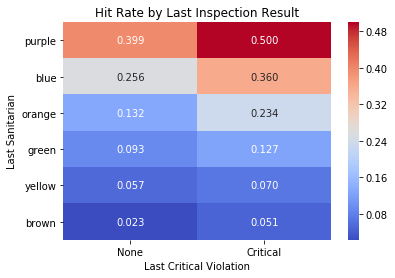

In [186]:
sns.heatmap(insp_pivot.values, cmap="coolwarm", annot=True, fmt=".3f")
plt.yticks(np.arange(0.5, 6, 1), insp_pivot.index, rotation="horizontal")
plt.xticks([0.5, 1.5], ["None", "Critical"])
plt.ylabel("Last Sanitarian")
plt.xlabel("Last Critical Violation")
plt.title("Hit Rate by Last Inspection Result")
plt.show()

In [96]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [97]:
CONT_VARS = ["heat_garbage", "temperatureMax", "heat_burglary", "heat_sanitation"]
for var in CONT_VARS:
    mu = d_train[var].mean()
    sigma = d_train[var].std()
    d_train[var + "_scaled"] = (d_train[var] - mu) / sigma
    d_test[var + "_scaled"] = (d_test[var] - mu) / sigma

In [98]:
for feat in ["pastCritical", "pastSerious"]:
    for insp in INSPECTORS_SORTED:
        d_train[insp + "_bipolar_" + feat] = ((2 * d_train[feat]) - 1) * d_train[insp]
        d_test[insp + "_bipolar_" + feat] = ((2 * d_test[feat]) - 1) * d_test[insp]
        d_train[insp + "_had_" + feat] = d_train[feat] * d_train[insp]
        d_test[insp + "_had_" + feat] = d_test[feat] * d_test[insp]
        d_train[insp + "_no_" + feat] = (1 - d_train[feat]) * d_train[insp]
        d_test[insp + "_no_" + feat] = (1 - d_test[feat]) * d_test[insp]

In [100]:
new_crit = [insp + "_had_pastCritical" for insp in INSPECTORS_SORTED] + [insp + "_no_pastCritical" for insp in INSPECTORS_SORTED]
new_ser = [insp + "_had_pastSerious" for insp in INSPECTORS_SORTED] + [insp + "_no_pastSerious" for insp in INSPECTORS_SORTED]
new_cont = [var + "_scaled" for var in CONT_VARS]
new_vars = [
    "timeSinceLast",
    "ageAtInspection",
    "consumption_on_premises_incidental_activity",
    "tobacco_retail_over_counter"
] + new_crit + new_ser + new_cont

In [101]:
X_train_new = d_train[new_vars]
X_test_new = d_test[new_vars]

In [102]:
X_train_new.head(10).T

,0,1,2,3,4,5,6,7,8,9
timeSinceLast,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
ageAtInspection,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
consumption_on_premises_incidental_activity,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
tobacco_retail_over_counter,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Inspector_purple_had_pastCritical,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Inspector_blue_had_pastCritical,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Inspector_orange_had_pastCritical,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Inspector_green_had_pastCritical,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Inspector_yellow_had_pastCritical,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Inspector_brown_had_pastCritical,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [103]:
logit = LogisticRegression(solver="lbfgs", max_iter=1000, penalty="l2")
logit.fit(X_train_new, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [104]:
evaluate_model(y_test, logit.predict(X_test_new))

F1 Score = 0.07942
Precision = 0.57895
Recall = 0.04264


,Predicted +,Predicted -
Actual +,11,247
Actual -,8,1371


In [105]:
roc_auc_score(y_test, logit.predict(X_test_new))

0.51841717681051891

In [106]:
pd.DataFrame({"Variable": new_vars, "Coefficient": logit.coef_[0]})

,Variable,Coefficient
0,timeSinceLast,0.090979
1,ageAtInspection,-0.166078
2,consumption_on_premises_incidental_activity,0.409280
3,tobacco_retail_over_counter,0.171053
4,Inspector_purple_had_pastCritical,0.937558
5,Inspector_blue_had_pastCritical,0.702550
6,Inspector_orange_had_pastCritical,0.414472
7,Inspector_green_had_pastCritical,0.010716
8,Inspector_yellow_had_pastCritical,-0.382739
9,Inspector_brown_had_pastCritical,-0.326225
